# Fitting PAT measurements

Authors: Pieter Eendebak, Sjaak van Diepen

The core package for this example is `qtt.algorithms.pat_fitting`. We use this package to analyse the data from a photon-assisted-tunneling measurement performed on 2-dot system, and extract the tunnel coupling and lever arm from the measurement.

For more information on PAT measurements and fitting see "Automated tuning of inter-dot tunnel coupling in double quantum dots", https://doi.org/10.1063/1.5031034

Import the modules used in this program:

In [3]:
import os, sys
import qcodes
import scipy.constants
import matplotlib.pyplot as plt
import numpy as np

from qcodes import MatPlot
import qtt
from qtt.data import load_example_dataset
from qtt.algorithms.tunneling import fit_pol_all, polmod_all_2slopes
from qtt.algorithms.pat_fitting import fit_pat, plot_pat_fit, pre_process_pat, show_traces, detect_peaks
%matplotlib inline  

## Load dataset

In [4]:
dataset_pat = load_example_dataset(os.path.join('2017-09-04', '11-05-17_qtt_scan2Dfastvec')) # main dataset for PAT analysis
dataset_pol = load_example_dataset(os.path.join('2017-09-04', '11-04-45_qtt_scan1Dfastvec')) # 1D trace of the background data

Set some parameters from the data.

In [5]:
la = 74.39 # [ueV/mV], lever arm
sweep_detun = {'P1': -1.1221663904980717, 'P2': 1.262974805193041} # [mV on gate / mV swept], sweep_detun * la = detuning in ueV
kb = scipy.constants.physical_constants['Boltzmann constant in eV/K'][0]*1e6  # [ueV/K]
Te = 98e-3*kb # [ueV], electron temperature
ueV2GHz = 1e15*scipy.constants.h/scipy.constants.elementary_charge # [GHz/ueV]

Show the PAT scan and the background data.

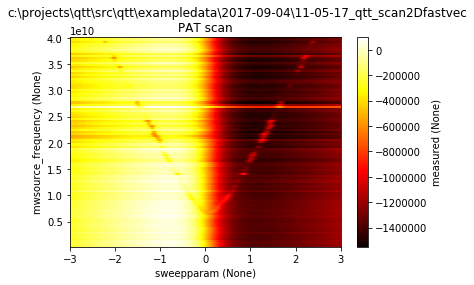

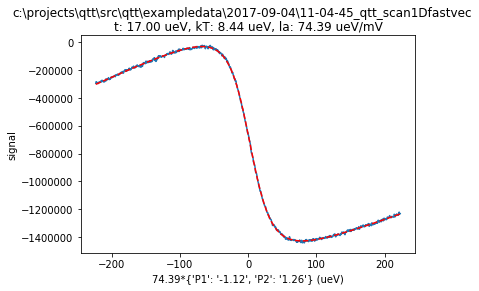

In [6]:
MatPlot(dataset_pat.default_parameter_array(), num=5)
plt.title('PAT scan')

pol_fit, pol_guess, _ = fit_pol_all(la*dataset_pol.sweepparam.ndarray, dataset_pol.measured1, kT=Te)  # 1 indicates fpga channel

fig_pol = plt.figure(10)
plt.plot(la*dataset_pol.sweepparam.ndarray, dataset_pol.measured1)
plt.plot(la*dataset_pol.sweepparam.ndarray, polmod_all_2slopes(la*dataset_pol.sweepparam.ndarray, pol_fit, kT=Te), 'r--')
plt.xlabel('%.2f*%s (ueV)' % (la,str({plg: '%.2f' % sweep_detun[plg] for plg in sweep_detun})))
plt.ylabel('signal')
plt.title('t: %.2f ueV, kT: %.2f ueV, la: %.2f ueV/mV' % (np.abs(pol_fit[0]), Te, la))
_=plt.suptitle(dataset_pol.location)

## Fit PAT model

In [7]:
x_data = dataset_pat.sweepparam.ndarray[0]
y_data = np.array(dataset_pat.mwsource_frequency)
z_data = np.array(dataset_pat.measured)
background = np.array(dataset_pol.default_parameter_array())

pp, pat_fit = fit_pat(x_data, y_data, z_data, background)
imq=pat_fit['imq']

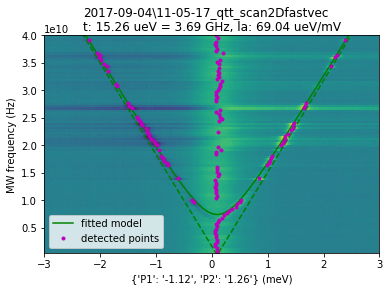

In [8]:
pat_fit_fig = plt.figure(100); plt.clf()
plot_pat_fit(x_data, y_data, imq, pp, fig=pat_fit_fig.number, label='fitted model')
plt.plot(pat_fit['xd'], pat_fit['yd'], '.m', label='detected points')
plt.title('t: %.2f ueV = %.2f GHz, la: %.2f ueV/mV' % (np.abs(pp[2]), np.abs(pp[2]/ueV2GHz), pp[1]))
plt.suptitle(dataset_pat.location)
plt.xlabel('%s (meV)' % (str({plg: '%.2f' % sweep_detun[plg] for plg in sweep_detun})))
plt.ylabel('MW frequency (Hz)')
_=plt.legend()

## Fit 2-electron model

In [9]:
dataset_pat = qcodes.load_data(r'misc\2electron_pat_26102017\pat')
dataset_pol = qcodes.load_data(r'misc\2electron_pat_26102017\background')

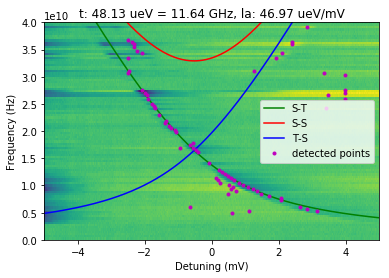

In [11]:
x_data = dataset_pat.sweepparam.ndarray[0]
y_data = np.array(dataset_pat.mwsource_frequency)
z_data = np.array(dataset_pat.measured)
background = np.array(dataset_pol.default_parameter_array())

pp, pat_fit = fit_pat(x_data, y_data, z_data, background, trans='two_ele', even_branches=[True, False, False])
imq=pat_fit['imq']

plot_pat_fit(x_data, y_data, imq, pp, fig=pat_fit_fig.number, label='fitted model', trans='two_ele')
plt.plot(pat_fit['xd'], pat_fit['yd'], '.m', label='detected points')
plt.title('t: %.2f ueV = %.2f GHz, la: %.2f ueV/mV' % (np.abs(pp[2]), np.abs(pp[2]/ueV2GHz), pp[1]))
_=plt.legend()

## Show pre-processing and intermediate steps

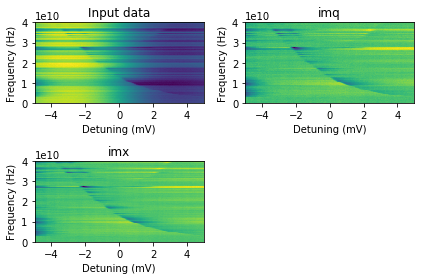

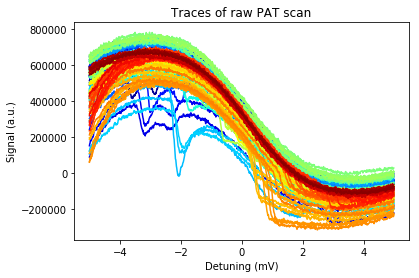

In [12]:
imx, imq, _ = pre_process_pat(x_data, y_data, background, z_data, fig=100)
show_traces(x_data, z_data, fig=101, direction='h', title='Traces of raw PAT scan')

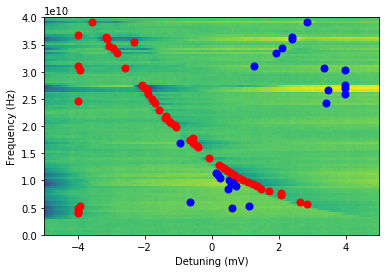

In [13]:
xx, _ = detect_peaks(x_data, y_data, imx, sigmamv=.05, fig=200)